Mount to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import dependencies.

In [2]:
import os, glob, torch, sys, json, random, math
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

Set the SEED to ensure reproducability.

In [3]:
def set_seed(seed: int = 42):
    import random, torch, os
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    return seed

seed = set_seed(42)

Define the directory.

In [4]:
root_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'WQF7002 Group Project')
data_dir = os.path.join(root_dir, 'wlasl_reduced')
video_dir = os.path.join(data_dir, 'videos')
pose_dir = os.path.join(data_dir, 'features_kps')
save_dir = os.path.join(root_dir, 'weights', 'sstan')

# add the notebook directory to sys.path
sys.path.insert(0, os.path.join(root_dir, 'notebook'))

Load the gloss map.

In [5]:
gloss_path = os.path.join(data_dir, "gloss_map.json")
with open(gloss_path, "r") as f:
    gloss_map = json.load(f)

Load the metadata.

In [6]:
data = []

for entry in os.scandir(pose_dir):
    if entry.is_dir():
        gloss = entry.name

        for file_entry in os.scandir(entry.path):
            if file_entry.is_file() and file_entry.name.endswith('.npy'):

                video_id = file_entry.name[:-4]
                data.append({
                    "gloss": gloss,
                    "video_id": video_id,
                })

df = pd.DataFrame(data)
df.head(5)

,gloss,video_id
0,bad,04712
1,bad,04708
2,bad,04709
3,bad,04713
4,bad,04718


#### Build Sign Dataset

In [31]:
class SkeletonAugmentation:
    def __init__(self, rot_range=15, shift_range=0.1):
        self.rot_range = rot_range
        self.shift_range = shift_range

    def __call__(self, x):
        x = x.clone()

        theta_deg = (random.random() * 2 - 1) * self.rot_range
        theta_rad = math.radians(theta_deg)

        # random shifts between -shift_range and +shift_range
        dx = (random.random() * 2 - 1) * self.shift_range
        dy = (random.random() * 2 - 1) * self.shift_range

        # precompute Sine and Cosine
        cos_theta = math.cos(theta_rad)
        sin_theta = math.sin(theta_rad)

        # extract Coordinates
        x_coords = x[0, :, :]
        y_coords = x[1, :, :]

        # apply rotation formula
        x_new = (x_coords * cos_theta) - (y_coords * sin_theta)
        y_new = (x_coords * sin_theta) + (y_coords * cos_theta)

        # apply shifting formula
        x_new = x_new + dx
        y_new = y_new + dy

        # update the Tensor
        x[0, :, :] = x_new
        x[1, :, :] = y_new

        return x

In [32]:
class SignDataset(Dataset):
    def __init__(self, df, pose_root, gloss_map, transform=None):
        self.df = df
        self.pose_root = pose_root
        self.gloss_map = gloss_map
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def _convert_npy_to_tensor(self, npy_path):
        data = np.load(npy_path)

        # convert to Tensor and permute to (C, T, V)
        tensor = torch.tensor(data, dtype=torch.float32)
        return tensor

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_id = str(row["video_id"])
        gloss = row["gloss"]
        label = self.gloss_map[gloss]

        video_path = os.path.join(self.pose_root, gloss, f"{video_id}.npy")
        x = self._convert_npy_to_tensor(video_path) # (3, T, V)

        if hasattr(self, 'transform') and self.transform is not None:
            x = self.transform(x)

        return {
            "x": x,
            "label": torch.tensor(label, dtype=torch.long),
            "video_id": idx
        }

Peek at a single data from Dataset.

In [33]:
g = torch.Generator()
g.manual_seed(seed)
train_dataset = SignDataset(df, pose_dir, gloss_map)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, generator=g)

sample = train_loader.dataset[300]
x = sample["x"]
label = sample["label"]
video_id = sample["video_id"]

print(x.shape, label, video_id)

torch.Size([3, 32, 75]) tensor(27) 300


### Sequential Spatio-Temporal Attention Network (SSTAN)

#### Build Skeleton Embedding

The skeleton data as input data fed into embedding layer which changes coordinates into embedding vectors. Then, the embedding vectors were concatenated with class token, added with Sinusoidal Positional Encoding, and passed multiple spatial temporal transformer blocks.

In [34]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, seq_length, dropout=0.25) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_length = seq_length
        self.dropout = torch.nn.Dropout(p=dropout)

        # create a metrix of shape (seq_length, d_model)
        pe = torch.zeros(seq_length, d_model)

        pos = torch.arange(start=0, end=seq_length, dtype=torch.float).unsqueeze(1) # (seq_length, 1)
        div_term = torch.exp( torch.arange(start=0, end=d_model, step=2) * (-np.log(10000.0) / d_model) )

        # apply the sin and cos function
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)

        pe = pe.unsqueeze(0) # (1, seq_length, d_model)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :].unsqueeze(2))
        return self.dropout(x)


class SkeletonEmbedding(nn.Module):
    def __init__(self, in_channels, d_model, max_frames):
        super().__init__()
        self.embedding = nn.Linear(in_channels, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.d_model = d_model
        max_len = max_frames + 1
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        B, C, T, V = x.shape
        x = x.permute(0, 2, 3, 1)                           # (B, T, V, C)
        x = x.contiguous().view(B, T * V, C)                # (B, T * V, C)
        x = self.embedding(x)                               # (B, T * V, C_emb)
        x = x.view(B, T, V, -1)                             # (B, T, V, C_emb)
        cls_token = self.cls_token.expand(B, -1, V, -1)     # (B, 1, V, C_emb)
        x = torch.cat([cls_token, x], dim=1)                # (B, T+1, V, C_emb)
        x = self.pos_encoder(x)
        x = self.dropout(x)
        return x

Check the output shape.

In [35]:
x = torch.randn(1, 3, 32, 67)
embedding = SkeletonEmbedding(3, 128, 32)

with torch.no_grad():
    output = embedding(x)

print(output.shape)

torch.Size([1, 33, 67, 128])


#### Build Spatial Attention Block

Input embedding vectors fed into each linear layer to product *query*, *key*, and *value*. These process are expressed as follows:

$$
\begin{aligned}
\text{query} = W_q(x) \\
\text{key} = W_k(x) \\
\text{value} = W_v(x)
\end{aligned}
$$
<br>
Then, the attention map was calculated by the dot product operation with *query* and *key*. Finally, the output of attention was computed by *matmul* operator with attention map and *value*, and projected by output’s linear layer as follows:

$$
\begin{aligned}
\text{output} = W_o(\text{matmul}(\text{attention}, v))
\end{aligned}
$$

In [36]:
class SpatialAttentionBlock(nn.Module):
    def __init__(self, d_model, num_heads, head_dim, seq_len, dropout=0.25):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.d_k = num_heads * head_dim
        self.seq_len = seq_len

        self.W_q = nn.Linear(d_model, self.d_k)
        self.W_k = nn.Linear(d_model, self.d_k)
        self.W_v = nn.Linear(d_model, self.d_k)
        self.W_o = nn.Linear(self.d_k, d_model)

    def forward(self, x):
        B, T, V, C = x.shape
        x = x.contiguous().view(B, T * V, C)                # (B, 51 * 67, 128)

        q = self.W_q(x)                                     # (B, 51 * 67, 512)
        k = self.W_k(x)                                     # (B, 51 * 67, 512)
        v = self.W_v(x)                                     # (B, 51 * 67, 512)

        # reshape: (B, T, V, num_heads, head_dim)
        q = q.view(B, T, V, self.num_heads, self.head_dim)
        k = k.view(B, T, V, self.num_heads, self.head_dim)
        v = v.view(B, T, V, self.num_heads, self.head_dim)

        # reshape: (B, T, num_heads, V, head_dim)
        q = q.permute(0, 1, 3, 2, 4)
        k = k.permute(0, 1, 3, 2, 4)
        v = v.permute(0, 1, 3, 2, 4)

        scores = torch.matmul(q, k.transpose(-2, -1))       # (B, T, num_heads, V, V)
        scores /= np.sqrt(self.head_dim)
        attn_map = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn_map, v)                  # (B, T, num_heads, V, head_dim)
        output = output.permute(0, 1, 3, 2, 4)              # (B, T, V, num_heads, head_dim)
        output = output.contiguous().view(B, T*V, self.d_k) # (B, T * V, d_k)
        output = self.W_o(output)                           # (B, T * V, d_model)
        output = output.view(B, T, V, -1)                   # (B, T, V, d_model)
        return output

Check the output shape.

In [37]:
x = torch.rand(1, 33, 67, 128)
block = SpatialAttentionBlock(128, 8, 64, 67)

with torch.no_grad():
    output = block(x)

print(output.shape)

torch.Size([1, 33, 67, 128])


#### Build Temporal Attention Block

**Note**: The input embedding vector was transposed in spatial and temporal dimensions before being passed to this module.

In [38]:
from irpe import iRPE
class TemporalAttentionBlock(nn.Module):
    def __init__(self, d_model, num_heads, head_dim, seq_len, dropout=0.25):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.d_k = num_heads * head_dim
        self.seq_len = seq_len

        self.W_q = nn.Linear(d_model, self.d_k)
        self.W_k = nn.Linear(d_model, self.d_k)
        self.W_v = nn.Linear(d_model, self.d_k)
        self.W_o = nn.Linear(self.d_k, d_model)

        self.relative_pos = iRPE(
            self.head_dim, self.num_heads, mode="contextual",
            num_buckets=2*seq_len-1, method=0
        )
        self.register_buffer("rp_bucket", self._make_1d_buckets(33))

    def _make_1d_buckets(self, seq_len):
        arange = torch.arange(seq_len)
        buckets = arange[:, None] - arange[None, :] + (seq_len - 1)
        return buckets.long()

    def forward(self, x):
        B, V, T, C = x.shape
        x = x.contiguous().view(B, T * V, C)                # (B, 67 * 51, 128)

        q = self.W_q(x)                                     # (B, 67 * 51, 512)
        k = self.W_k(x)                                     # (B, 67 * 51, 512)
        v = self.W_v(x)                                     # (B, 67 * 51, 512)

        # reshape: (B, V, T, num_heads, head_dim)
        q = q.view(B, V, T, self.num_heads, self.head_dim)
        k = k.view(B, V, T, self.num_heads, self.head_dim)
        v = v.view(B, V, T, self.num_heads, self.head_dim)

        # reshape: (B, V, num_heads, T, head_dim)
        q = q.permute(0, 1, 3, 2, 4)
        k = k.permute(0, 1, 3, 2, 4)
        v = v.permute(0, 1, 3, 2, 4)

        scores = torch.matmul(q, k.transpose(-2, -1))                           # (B, V, num_heads, T, T)

        # --- Start RPE Application ---
        q_rpe = q.contiguous().view(B*V, self.num_heads, T, self.head_dim)      # (V, num_heads, T, head_dim)
        cur_buckets = self.rp_bucket[:T, :T]
        num_buckets = self.relative_pos.num_buckets
        offsets = torch.arange(
            0, T * num_buckets, num_buckets,
            device=cur_buckets.device, dtype=cur_buckets.dtype
        ).view(-1, 1)
        ctx_indices = (cur_buckets + offsets).flatten()
        self.relative_pos._ctx_rp_bucket_flatten = ctx_indices
        pos_score = self.relative_pos.forward_rpe_transpose(q_rpe, cur_buckets) # (B * V, num_heads, T, T)
        pos_score = pos_score.view(B, V, self.num_heads, T, T)                  # (B, V, num_heads, T, T)
        # --- End RPE Application ---

        scores = (scores + pos_score)
        scores /= np.sqrt(self.head_dim)
        attn_map = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn_map, v)                                      # (B, V, num_heads, T, head_dim)

        output = output.permute(0, 1, 3, 2, 4)                                  # (B, V, T, num_heads, head_dim)
        output = output.contiguous().view(B, V * T, self.d_k)                   # (B, V * T, d_k)
        output = self.W_o(output)                                               # (B, V * T, C_emb)
        output = output.contiguous().view(B, V, T, -1)                          # (B, V , T, C_emd)
        return output

Check the output shape.

In [39]:
x = torch.randn(1, 33, 67, 128)
temporal_block = TemporalAttentionBlock(128, 8, 64, 67)

with torch.no_grad():
    x = x.permute(0, 2, 1, 3)
    output = temporal_block(x)

print(output.shape)

torch.Size([1, 67, 33, 128])


#### Build Feed Forward Network

The feed forward network that has *two linear projection layers* and *one activation function*. The input vector is *expanded to a dimension 4.0 times larger* than the embedding dimension by a first linear projection layer then nonlinearly transformed via an GELU activation function, and then converted back to a lower dimension by another linear projection layer, where the vector is merged by addition.
<br><br>
This process is expressed as follows:

$$
\begin{aligned}
x_{ff_n} &= GELU(W_1(x)) \\
x &= W_2(x_{ff_n})+x
\end{aligned}
$$


In [40]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, expand_ratio=4.0, dropout=0.25):
        super().__init__()
        hidden_dim = int(d_model * expand_ratio)
        self.fc1 = nn.Linear(d_model, hidden_dim)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, d_model)

    def forward(self, x):
        x_ff = self.fc1(x)
        x_ff = self.gelu(x_ff)
        x = self.fc2(x_ff) + x
        return x

Check the output shape.

In [41]:
x = torch.randn(1, 33, 67, 128)
network = FeedForwardNetwork(128)

with torch.no_grad():
    output = network(x)

print(output.shape)

torch.Size([1, 33, 67, 128])


#### Build Spatial-Temporal Transformer Block

This block mainly consisted of 3 components : Multihead Self-Attention for spatial dimension, Multihead Self-Attention for tempral dimension with Relative Positional Encoding, and Feed Forward Network. Applied B2T Connection to skips all sub-layer to stable the side effect of Post-Norm.

In [42]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, head_dim, seq_len, expand_ratio=4.0, dropout=0.25):
        super().__init__()
        self.spatial_block = SpatialAttentionBlock(d_model, num_heads, head_dim, seq_len)
        self.temporal_block = TemporalAttentionBlock(d_model, num_heads, head_dim, seq_len)
        self.ffn = FeedForwardNetwork(d_model, expand_ratio, dropout)
        self.bn1 = nn.BatchNorm2d(d_model)
        self.bn2 = nn.BatchNorm2d(d_model)
        self.bn3 = nn.BatchNorm2d(d_model)

    def forward(self, x):
        B, T, V, C = x.shape
        residual = x
        output = self.spatial_block(x)          # (B, T, V, C_emb)
        output = output + residual              # (B, T, V, C_emb)

        output = output.permute(0, 3, 2, 1)     # (B, C_emb, V, T)
        output = self.bn1(output)
        output = output.permute(0, 3, 2, 1)     # (B, T, V, C_emb)

        residual = output
        output = output.permute(0, 2, 1, 3)     # (B, V, T, C_emb)
        output = self.temporal_block(output)    # (B, V, T, C_emd)
        output = output.permute(0, 2, 1, 3)     # (B, T, V, C_emb)
        output = output + residual

        output = output.permute(0, 3, 2, 1)      # (B, C_emb, V, T)
        output = self.bn2(output)
        output = output.permute(0, 3, 2, 1)      # (B, T, V, C_emb)

        residual = output
        output = self.ffn(output)                # (B, T, V, C_emb)
        output = x + residual + output           # B2T connection logic

        output = output.permute(0, 3, 2, 1)      # (B, C_emb, V, T)
        output = self.bn3(output)
        output = output.permute(0, 3, 2, 1)      # (B, T, V, C_emb)

        return output

Check the ouput shape.

In [43]:
x = torch.randn(1, 33, 67, 128)
block = TransformerBlock(128, 8, 64, 67)

with torch.no_grad():
    output = block(x)

print(output.shape)

torch.Size([1, 33, 67, 128])


#### Build Stack Transformer Model (SSTAN)

In [44]:
class SSTAN(nn.Module):
    def __init__(self, num_classes, max_frames, in_channels=3, seq_len=67, d_model=128, num_heads=4, head_dim=64, num_layers=5):
        super().__init__()
        self.embedding = SkeletonEmbedding(in_channels, d_model, max_frames)
        self.transformer_encoder = nn.ModuleList([TransformerBlock(d_model, num_heads, head_dim, seq_len) for _ in range(num_layers)])
        self.classifier = nn.Sequential(
            # nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)                       # (B, C, T, V)

        for block in self.transformer_encoder:
            x = block(x)
        cls_output = x[:, 0, :].mean(dim=1)         # (B, C_emb)

        logits = self.classifier(cls_output)
        return logits

In [45]:
x = torch.randn(1, 3, 32, 67)
model = SSTAN(35, 32)

with torch.no_grad():
    output = model(x)

print(output.shape)

torch.Size([1, 35])


#### Training Loop

Define Early Stopping Mechanism

In [46]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, save_dir=''):
        self.patience = patience
        self.min_delta = min_delta
        self.save_dir = save_dir
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model, val_loss, epoch)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model, val_loss, epoch)
            self.counter = 0

    def save_checkpoint(self, model, val_loss, epoch):
        file_name = f"vqa_epoch{epoch+1}_loss{val_loss:.4f}.pth"
        save_path = os.path.join(self.save_dir, file_name)

        torch.save(model.state_dict(), save_path)
        print(f'Model saved to {save_path}')

Define how the data is being split.

In [47]:
from sklearn.model_selection import train_test_split

val_size, test_size= 0.15, 0.15
temp_size = val_size + test_size
relative_test_size = test_size / (val_size + test_size)

train_df, temp_df = train_test_split(df, test_size=temp_size, stratify=df['gloss'], random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=relative_test_size, stratify=temp_df['gloss'], random_state=seed)

print("Shape check:")
print(f"Train: {len(train_df)}")
print(f"Val:   {len(val_df)}")
print(f"Test:  {len(test_df)}")

Shape check:
Train: 236
Val:   79
Test:  79


Define the hyperparameters.

In [55]:
epochs = 200
batch_size = 128
learning_rate = 7e-3
num_classes = 35
num_frames = 32

Define the Dataset and DataLoader.

In [56]:
g = torch.Generator()
g.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

augmentor = SkeletonAugmentation(rot_range=15, shift_range=0.1)
train_dataset = SignDataset(train_df, pose_dir, gloss_map, augmentor)
val_dataset = SignDataset(val_df, pose_dir, gloss_map)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, generator=g)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, generator=g)

Train the SSTAN model

In [57]:
# setup
model = SSTAN(num_classes, num_frames, num_heads=4, num_layers=5).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# define scheduler
warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1e-10, end_factor=1.0, total_iters=5)
cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs-5, eta_min=1e-6)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[5])
early_stopper = EarlyStopping(patience=5, save_dir=save_dir)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    # ------------ training phrase ------------
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    optimizer.zero_grad()
    batch_iterator = tqdm(train_loader, leave=True, desc=f'Processing epoch {epoch+1:02d}')

    for i, batch in enumerate(batch_iterator):
        inputs = batch["x"].to(device)
        labels = batch["label"].to(device)
        video_id = batch["video_id"].to(device)

        print(inputs.shape)

        # forward pass
        logits = model(inputs)
        loss = criterion(logits, labels)

        # backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        current_loss = loss.item()
        train_loss += current_loss

        _, predicted = torch.max(logits.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()

        train_correct += correct
        train_total += total

        # update progress bar
        batch_iterator.set_postfix(
            loss=f"{current_loss:.4f}",
            acc=f"{(correct/total)*100:.2f}",
            lr=f"{optimizer.param_groups[0]['lr']:.2e}"
        )

    # calculate average training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100. * train_correct / train_total

    # ------------ validation phrase ------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch["x"].to(device)
            labels = batch["label"].to(device)
            video_id = batch["video_id"].to(device)

            # forward pass
            logits = model(inputs)
            loss = criterion(logits, labels)

            # update statistics
            val_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # calculate average validation metrics
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100. * val_correct / val_total

    # update learning rate scheduler
    scheduler.step()

    # store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # print epoch results
    print(f'\nEpoch [{epoch+1}/{epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # check early stopping
    # early_stopper(avg_val_loss, model, epoch)
    # if early_stopper.early_stop and epoch > 5:
    #         print("Early stopping triggered. Training finished.")
    #         break

    print('-' * 60)

Processing epoch 01:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 01:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=3.12, loss=3.9828, lr=7.00e-13]

torch.Size([108, 3, 32, 75])


Processing epoch 01: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=3.70, loss=3.9678, lr=7.00e-13]



Epoch [1/200]
Train Loss: 3.9753, Train Acc: 3.39%
Val Loss: 50.0600, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 02:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 02:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=3.12, loss=3.9173, lr=1.40e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 02: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=4.63, loss=4.2803, lr=1.40e-03]



Epoch [2/200]
Train Loss: 4.0988, Train Acc: 3.81%
Val Loss: 18.1751, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 03:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 03:  50%|█████     | 1/2 [00:01<00:01,  1.38s/it, acc=3.12, loss=3.9066, lr=2.80e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 03: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it, acc=3.70, loss=3.8318, lr=2.80e-03]



Epoch [3/200]
Train Loss: 3.8692, Train Acc: 3.39%
Val Loss: 16.0623, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 04:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 04:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=7.03, loss=3.5325, lr=4.20e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 04: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=2.78, loss=3.5677, lr=4.20e-03]



Epoch [4/200]
Train Loss: 3.5501, Train Acc: 5.08%
Val Loss: 217.9988, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 05:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 05:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=7.03, loss=3.3871, lr=5.60e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 05: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=7.41, loss=3.3618, lr=5.60e-03]



Epoch [5/200]
Train Loss: 3.3745, Train Acc: 7.20%
Val Loss: 258.4273, Val Acc: 6.33%
------------------------------------------------------------


Processing epoch 06:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 06:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=10.16, loss=3.1742, lr=7.00e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 06: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=3.70, loss=3.5477, lr=7.00e-03]



Epoch [6/200]
Train Loss: 3.3610, Train Acc: 7.20%
Val Loss: 629.2020, Val Acc: 7.59%
------------------------------------------------------------


Processing epoch 07:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 07:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, acc=8.59, loss=3.3066, lr=7.00e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 07: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=1.85, loss=3.9020, lr=7.00e-03]



Epoch [7/200]
Train Loss: 3.6043, Train Acc: 5.51%
Val Loss: 1304.1238, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 08:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 08:  50%|█████     | 1/2 [00:01<00:01,  1.38s/it, acc=7.81, loss=3.3684, lr=7.00e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 08: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=12.04, loss=3.3208, lr=7.00e-03]



Epoch [8/200]
Train Loss: 3.3446, Train Acc: 9.75%
Val Loss: 908.6526, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 09:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 09:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=7.81, loss=3.3791, lr=7.00e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 09: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=3.70, loss=3.4512, lr=7.00e-03]



Epoch [9/200]
Train Loss: 3.4152, Train Acc: 5.93%
Val Loss: 752.3488, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 10:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 10:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=5.47, loss=3.3625, lr=6.99e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 10: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=6.48, loss=3.3668, lr=6.99e-03]



Epoch [10/200]
Train Loss: 3.3646, Train Acc: 5.93%
Val Loss: 237.3976, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 11:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 11:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=7.03, loss=3.3788, lr=6.99e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 11: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=5.56, loss=3.5152, lr=6.99e-03]



Epoch [11/200]
Train Loss: 3.4470, Train Acc: 6.36%
Val Loss: 204.4232, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 12:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 12:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=7.03, loss=3.6566, lr=6.98e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 12: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=1.85, loss=3.7628, lr=6.98e-03]



Epoch [12/200]
Train Loss: 3.7097, Train Acc: 4.66%
Val Loss: 279.7071, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 13:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 13:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=4.69, loss=3.7906, lr=6.98e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 13: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=4.63, loss=3.7193, lr=6.98e-03]



Epoch [13/200]
Train Loss: 3.7549, Train Acc: 4.66%
Val Loss: 333.8621, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 14:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 14:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=9.38, loss=3.9194, lr=6.97e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 14: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=3.70, loss=3.7997, lr=6.97e-03]



Epoch [14/200]
Train Loss: 3.8596, Train Acc: 6.78%
Val Loss: 60.3514, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 15:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 15:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=7.03, loss=3.8557, lr=6.96e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 15: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=6.48, loss=3.7421, lr=6.96e-03]



Epoch [15/200]
Train Loss: 3.7989, Train Acc: 6.78%
Val Loss: 40.8824, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 16:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 16:  50%|█████     | 1/2 [00:01<00:01,  1.38s/it, acc=4.69, loss=3.7674, lr=6.95e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 16: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it, acc=3.70, loss=3.7248, lr=6.95e-03]



Epoch [16/200]
Train Loss: 3.7461, Train Acc: 4.24%
Val Loss: 55.3860, Val Acc: 6.33%
------------------------------------------------------------


Processing epoch 17:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 17:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=1.56, loss=3.8248, lr=6.95e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 17: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=5.56, loss=3.8713, lr=6.95e-03]



Epoch [17/200]
Train Loss: 3.8480, Train Acc: 3.39%
Val Loss: 36.2769, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 18:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 18:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=4.69, loss=3.8553, lr=6.93e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 18: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=3.70, loss=3.7653, lr=6.93e-03]



Epoch [18/200]
Train Loss: 3.8103, Train Acc: 4.24%
Val Loss: 27.3892, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 19:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 19:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=4.69, loss=3.8055, lr=6.92e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 19: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=4.63, loss=3.9552, lr=6.92e-03]



Epoch [19/200]
Train Loss: 3.8804, Train Acc: 4.66%
Val Loss: 19.9811, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 20:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 20:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=2.34, loss=3.9729, lr=6.91e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 20: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=6.48, loss=3.8147, lr=6.91e-03]



Epoch [20/200]
Train Loss: 3.8938, Train Acc: 4.24%
Val Loss: 19.2048, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 21:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 21:  50%|█████     | 1/2 [00:01<00:01,  1.37s/it, acc=3.12, loss=3.9208, lr=6.90e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 21: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it, acc=1.85, loss=4.2503, lr=6.90e-03]



Epoch [21/200]
Train Loss: 4.0856, Train Acc: 2.54%
Val Loss: 14.0032, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 22:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 22:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=0.78, loss=4.0594, lr=6.88e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 22: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=3.70, loss=3.7076, lr=6.88e-03]



Epoch [22/200]
Train Loss: 3.8835, Train Acc: 2.12%
Val Loss: 11.3555, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 23:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 23:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=4.69, loss=3.8186, lr=6.87e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 23: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=4.63, loss=3.8134, lr=6.87e-03]



Epoch [23/200]
Train Loss: 3.8160, Train Acc: 4.66%
Val Loss: 8.3701, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 24:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 24:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, acc=4.69, loss=3.8985, lr=6.85e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 24: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=0.93, loss=3.9369, lr=6.85e-03]



Epoch [24/200]
Train Loss: 3.9177, Train Acc: 2.97%
Val Loss: 5.5600, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 25:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 25:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, acc=5.47, loss=3.9131, lr=6.84e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 25: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=0.93, loss=3.7295, lr=6.84e-03]



Epoch [25/200]
Train Loss: 3.8213, Train Acc: 3.39%
Val Loss: 4.5165, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 26:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 26:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=6.25, loss=3.7376, lr=6.82e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 26: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=1.85, loss=3.8153, lr=6.82e-03]



Epoch [26/200]
Train Loss: 3.7765, Train Acc: 4.24%
Val Loss: 4.1016, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 27:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 27:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=2.34, loss=3.8235, lr=6.80e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 27: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=6.48, loss=3.7445, lr=6.80e-03]



Epoch [27/200]
Train Loss: 3.7840, Train Acc: 4.24%
Val Loss: 4.3876, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 28:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 28:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=3.12, loss=3.6680, lr=6.78e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 28: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=5.56, loss=3.6878, lr=6.78e-03]



Epoch [28/200]
Train Loss: 3.6779, Train Acc: 4.24%
Val Loss: 5.5399, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 29:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 29:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=3.12, loss=3.7657, lr=6.76e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 29: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=5.56, loss=3.7088, lr=6.76e-03]



Epoch [29/200]
Train Loss: 3.7372, Train Acc: 4.24%
Val Loss: 5.2543, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 30:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 30:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=5.47, loss=3.6725, lr=6.74e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 30: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=5.56, loss=3.7216, lr=6.74e-03]



Epoch [30/200]
Train Loss: 3.6970, Train Acc: 5.51%
Val Loss: 3.9484, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 31:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 31:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=2.34, loss=3.7581, lr=6.72e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 31: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=6.48, loss=3.6668, lr=6.72e-03]



Epoch [31/200]
Train Loss: 3.7124, Train Acc: 4.24%
Val Loss: 3.7527, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 32:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 32:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=3.91, loss=3.7549, lr=6.70e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 32: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=5.56, loss=3.6636, lr=6.70e-03]



Epoch [32/200]
Train Loss: 3.7092, Train Acc: 4.66%
Val Loss: 3.9694, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 33:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 33:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=2.34, loss=3.6831, lr=6.67e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 33: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=3.70, loss=3.5661, lr=6.67e-03]



Epoch [33/200]
Train Loss: 3.6246, Train Acc: 2.97%
Val Loss: 3.8900, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 34:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 34:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, acc=3.12, loss=3.6803, lr=6.65e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 34: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=1.85, loss=3.7327, lr=6.65e-03]



Epoch [34/200]
Train Loss: 3.7065, Train Acc: 2.54%
Val Loss: 4.1984, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 35:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 35:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=1.56, loss=3.6822, lr=6.62e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 35: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=0.00, loss=3.7939, lr=6.62e-03]



Epoch [35/200]
Train Loss: 3.7381, Train Acc: 0.85%
Val Loss: 4.0600, Val Acc: 0.00%
------------------------------------------------------------


Processing epoch 36:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 36:  50%|█████     | 1/2 [00:01<00:01,  1.37s/it, acc=3.12, loss=3.7351, lr=6.60e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 36: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=2.78, loss=3.7444, lr=6.60e-03]



Epoch [36/200]
Train Loss: 3.7398, Train Acc: 2.97%
Val Loss: 3.8758, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 37:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 37:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=3.12, loss=3.8867, lr=6.57e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 37: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=4.63, loss=3.7783, lr=6.57e-03]



Epoch [37/200]
Train Loss: 3.8325, Train Acc: 3.81%
Val Loss: 3.6803, Val Acc: 6.33%
------------------------------------------------------------


Processing epoch 38:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 38:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, acc=3.12, loss=3.6949, lr=6.55e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 38: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=3.70, loss=3.7223, lr=6.55e-03]



Epoch [38/200]
Train Loss: 3.7086, Train Acc: 3.39%
Val Loss: 3.7784, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 39:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 39:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=3.91, loss=3.6821, lr=6.52e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 39: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=5.56, loss=3.8223, lr=6.52e-03]



Epoch [39/200]
Train Loss: 3.7522, Train Acc: 4.66%
Val Loss: 3.7941, Val Acc: 0.00%
------------------------------------------------------------


Processing epoch 40:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 40:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=3.12, loss=3.7725, lr=6.49e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 40: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=3.70, loss=3.6674, lr=6.49e-03]



Epoch [40/200]
Train Loss: 3.7199, Train Acc: 3.39%
Val Loss: 4.0022, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 41:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 41:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=0.78, loss=3.7683, lr=6.46e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 41: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=3.70, loss=3.7274, lr=6.46e-03]



Epoch [41/200]
Train Loss: 3.7478, Train Acc: 2.12%
Val Loss: 3.9623, Val Acc: 0.00%
------------------------------------------------------------


Processing epoch 42:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 42:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, acc=5.47, loss=3.6181, lr=6.43e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 42: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=0.00, loss=3.8604, lr=6.43e-03]



Epoch [42/200]
Train Loss: 3.7392, Train Acc: 2.97%
Val Loss: 4.0751, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 43:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 43:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=5.47, loss=3.6321, lr=6.40e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 43: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=4.63, loss=3.7254, lr=6.40e-03]



Epoch [43/200]
Train Loss: 3.6787, Train Acc: 5.08%
Val Loss: 3.7068, Val Acc: 7.59%
------------------------------------------------------------


Processing epoch 44:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 44:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=4.69, loss=3.7831, lr=6.36e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 44: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=8.33, loss=3.7281, lr=6.36e-03]



Epoch [44/200]
Train Loss: 3.7556, Train Acc: 6.36%
Val Loss: 3.7195, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 45:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 45:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=0.78, loss=3.7542, lr=6.33e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 45: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=3.70, loss=3.7796, lr=6.33e-03]



Epoch [45/200]
Train Loss: 3.7669, Train Acc: 2.12%
Val Loss: 3.7454, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 46:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 46:  50%|█████     | 1/2 [00:01<00:01,  1.38s/it, acc=3.91, loss=3.6932, lr=6.30e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 46: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=3.70, loss=3.6675, lr=6.30e-03]



Epoch [46/200]
Train Loss: 3.6803, Train Acc: 3.81%
Val Loss: 3.6318, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 47:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 47:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=1.56, loss=3.8538, lr=6.26e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 47: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=4.63, loss=3.7021, lr=6.26e-03]



Epoch [47/200]
Train Loss: 3.7780, Train Acc: 2.97%
Val Loss: 3.6362, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 48:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 48:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=2.34, loss=3.6671, lr=6.23e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 48: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=6.48, loss=3.8687, lr=6.23e-03]



Epoch [48/200]
Train Loss: 3.7679, Train Acc: 4.24%
Val Loss: 3.8569, Val Acc: 6.33%
------------------------------------------------------------


Processing epoch 49:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 49:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=1.56, loss=3.6586, lr=6.19e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 49: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=3.70, loss=3.7802, lr=6.19e-03]



Epoch [49/200]
Train Loss: 3.7194, Train Acc: 2.54%
Val Loss: 3.8638, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 50:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 50:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=2.34, loss=3.7341, lr=6.16e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 50: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=3.70, loss=3.6304, lr=6.16e-03]



Epoch [50/200]
Train Loss: 3.6822, Train Acc: 2.97%
Val Loss: 4.0104, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 51:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 51:  50%|█████     | 1/2 [00:01<00:01,  1.39s/it, acc=2.34, loss=3.8305, lr=6.12e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 51: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it, acc=2.78, loss=3.7606, lr=6.12e-03]



Epoch [51/200]
Train Loss: 3.7955, Train Acc: 2.54%
Val Loss: 3.7922, Val Acc: 0.00%
------------------------------------------------------------


Processing epoch 52:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 52:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=3.12, loss=3.7521, lr=6.08e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 52: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=0.93, loss=3.7017, lr=6.08e-03]



Epoch [52/200]
Train Loss: 3.7269, Train Acc: 2.12%
Val Loss: 3.8902, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 53:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 53:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=2.34, loss=3.6026, lr=6.04e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 53: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=1.85, loss=3.7885, lr=6.04e-03]



Epoch [53/200]
Train Loss: 3.6955, Train Acc: 2.12%
Val Loss: 3.7953, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 54:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 54:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=4.69, loss=3.8077, lr=6.00e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 54: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=1.85, loss=3.7762, lr=6.00e-03]



Epoch [54/200]
Train Loss: 3.7919, Train Acc: 3.39%
Val Loss: 3.9887, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 55:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 55:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=4.69, loss=3.5794, lr=5.97e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 55: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=3.70, loss=3.6579, lr=5.97e-03]



Epoch [55/200]
Train Loss: 3.6186, Train Acc: 4.24%
Val Loss: 3.9210, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 56:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 56:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, acc=7.81, loss=3.6796, lr=5.92e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 56: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=2.78, loss=3.8160, lr=5.92e-03]



Epoch [56/200]
Train Loss: 3.7478, Train Acc: 5.51%
Val Loss: 3.8621, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 57:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 57:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=1.56, loss=3.8186, lr=5.88e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 57: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=5.56, loss=3.6993, lr=5.88e-03]



Epoch [57/200]
Train Loss: 3.7590, Train Acc: 3.39%
Val Loss: 4.0452, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 58:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 58:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=5.47, loss=3.7269, lr=5.84e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 58: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=1.85, loss=3.7877, lr=5.84e-03]



Epoch [58/200]
Train Loss: 3.7573, Train Acc: 3.81%
Val Loss: 3.7794, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 59:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 59:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=2.34, loss=3.8369, lr=5.80e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 59: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=2.78, loss=3.8099, lr=5.80e-03]



Epoch [59/200]
Train Loss: 3.8234, Train Acc: 2.54%
Val Loss: 4.0175, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 60:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 60:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=4.69, loss=3.6820, lr=5.76e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 60: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=0.00, loss=3.7066, lr=5.76e-03]



Epoch [60/200]
Train Loss: 3.6943, Train Acc: 2.54%
Val Loss: 3.6689, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 61:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 61:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=2.34, loss=3.7339, lr=5.71e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 61: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=1.85, loss=3.7817, lr=5.71e-03]



Epoch [61/200]
Train Loss: 3.7578, Train Acc: 2.12%
Val Loss: 3.7414, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 62:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 62:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=1.56, loss=3.7401, lr=5.67e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 62: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=0.93, loss=3.7476, lr=5.67e-03]



Epoch [62/200]
Train Loss: 3.7438, Train Acc: 1.27%
Val Loss: 3.6752, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 63:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 63:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=3.91, loss=3.7506, lr=5.63e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 63: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=6.48, loss=3.6878, lr=5.63e-03]



Epoch [63/200]
Train Loss: 3.7192, Train Acc: 5.08%
Val Loss: 3.6375, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 64:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 64:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=0.78, loss=3.7190, lr=5.58e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 64: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=7.41, loss=3.6319, lr=5.58e-03]



Epoch [64/200]
Train Loss: 3.6755, Train Acc: 3.81%
Val Loss: 3.7202, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 65:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 65:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, acc=3.91, loss=3.7619, lr=5.53e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 65: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=2.78, loss=3.6742, lr=5.53e-03]



Epoch [65/200]
Train Loss: 3.7180, Train Acc: 3.39%
Val Loss: 3.6846, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 66:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 66:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=0.78, loss=3.7706, lr=5.49e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 66: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=3.70, loss=3.7232, lr=5.49e-03]



Epoch [66/200]
Train Loss: 3.7469, Train Acc: 2.12%
Val Loss: 3.8023, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 67:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 67:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=4.69, loss=3.6885, lr=5.44e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 67: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=3.70, loss=3.7613, lr=5.44e-03]



Epoch [67/200]
Train Loss: 3.7249, Train Acc: 4.24%
Val Loss: 3.7321, Val Acc: 6.33%
------------------------------------------------------------


Processing epoch 68:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 68:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, acc=2.34, loss=3.7910, lr=5.39e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 68: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=1.85, loss=3.6872, lr=5.39e-03]



Epoch [68/200]
Train Loss: 3.7391, Train Acc: 2.12%
Val Loss: 3.7410, Val Acc: 8.86%
------------------------------------------------------------


Processing epoch 69:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 69:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=2.34, loss=3.6880, lr=5.35e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 69: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=3.70, loss=3.7310, lr=5.35e-03]



Epoch [69/200]
Train Loss: 3.7095, Train Acc: 2.97%
Val Loss: 3.7525, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 70:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 70:  50%|█████     | 1/2 [00:01<00:01,  1.37s/it, acc=3.91, loss=3.6439, lr=5.30e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 70: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=6.48, loss=3.6791, lr=5.30e-03]



Epoch [70/200]
Train Loss: 3.6615, Train Acc: 5.08%
Val Loss: 3.6386, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 71:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 71:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, acc=2.34, loss=3.7592, lr=5.25e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 71: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it, acc=3.70, loss=3.7183, lr=5.25e-03]



Epoch [71/200]
Train Loss: 3.7388, Train Acc: 2.97%
Val Loss: 3.6537, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 72:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 72:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=2.34, loss=3.6332, lr=5.20e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 72: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=3.70, loss=3.6228, lr=5.20e-03]



Epoch [72/200]
Train Loss: 3.6280, Train Acc: 2.97%
Val Loss: 3.6763, Val Acc: 6.33%
------------------------------------------------------------


Processing epoch 73:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 73:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=3.12, loss=3.7462, lr=5.15e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 73: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=3.70, loss=3.6806, lr=5.15e-03]



Epoch [73/200]
Train Loss: 3.7134, Train Acc: 3.39%
Val Loss: 3.6713, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 74:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 74:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=5.47, loss=3.6385, lr=5.10e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 74: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=3.70, loss=3.7210, lr=5.10e-03]



Epoch [74/200]
Train Loss: 3.6797, Train Acc: 4.66%
Val Loss: 3.6581, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 75:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 75:  50%|█████     | 1/2 [00:01<00:01,  1.37s/it, acc=0.78, loss=3.7115, lr=5.05e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 75: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=2.78, loss=3.6433, lr=5.05e-03]



Epoch [75/200]
Train Loss: 3.6774, Train Acc: 1.69%
Val Loss: 3.6178, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 76:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 76:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=5.47, loss=3.5988, lr=5.00e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 76: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=1.85, loss=3.7498, lr=5.00e-03]



Epoch [76/200]
Train Loss: 3.6743, Train Acc: 3.81%
Val Loss: 3.6002, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 77:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 77:  50%|█████     | 1/2 [00:01<00:01,  1.37s/it, acc=7.03, loss=3.6595, lr=4.95e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 77: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=3.70, loss=3.7181, lr=4.95e-03]



Epoch [77/200]
Train Loss: 3.6888, Train Acc: 5.51%
Val Loss: 3.6528, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 78:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 78:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=2.34, loss=3.5889, lr=4.90e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 78: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=7.41, loss=3.6611, lr=4.90e-03]



Epoch [78/200]
Train Loss: 3.6250, Train Acc: 4.66%
Val Loss: 3.7181, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 79:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 79:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, acc=1.56, loss=3.7220, lr=4.85e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 79: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=4.63, loss=3.6213, lr=4.85e-03]



Epoch [79/200]
Train Loss: 3.6716, Train Acc: 2.97%
Val Loss: 3.7766, Val Acc: 0.00%
------------------------------------------------------------


Processing epoch 80:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 80:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=2.34, loss=3.6526, lr=4.79e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 80: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=6.48, loss=3.5465, lr=4.79e-03]



Epoch [80/200]
Train Loss: 3.5996, Train Acc: 4.24%
Val Loss: 3.6636, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 81:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 81:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=1.56, loss=3.6101, lr=4.74e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 81: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=2.78, loss=3.7155, lr=4.74e-03]



Epoch [81/200]
Train Loss: 3.6628, Train Acc: 2.12%
Val Loss: 3.6859, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 82:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 82:  50%|█████     | 1/2 [00:01<00:01,  1.38s/it, acc=3.12, loss=3.5889, lr=4.69e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 82: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it, acc=3.70, loss=3.6304, lr=4.69e-03]



Epoch [82/200]
Train Loss: 3.6096, Train Acc: 3.39%
Val Loss: 3.5908, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 83:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 83:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=3.91, loss=3.5902, lr=4.64e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 83: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=1.85, loss=3.6290, lr=4.64e-03]



Epoch [83/200]
Train Loss: 3.6096, Train Acc: 2.97%
Val Loss: 3.6096, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 84:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 84:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, acc=3.91, loss=3.5778, lr=4.58e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 84: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=4.63, loss=3.6039, lr=4.58e-03]



Epoch [84/200]
Train Loss: 3.5909, Train Acc: 4.24%
Val Loss: 3.5994, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 85:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 85:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=3.12, loss=3.6432, lr=4.53e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 85: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=3.70, loss=3.5737, lr=4.53e-03]



Epoch [85/200]
Train Loss: 3.6085, Train Acc: 3.39%
Val Loss: 3.5811, Val Acc: 8.86%
------------------------------------------------------------


Processing epoch 86:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 86:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=3.91, loss=3.6680, lr=4.47e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 86: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=2.78, loss=3.6781, lr=4.47e-03]



Epoch [86/200]
Train Loss: 3.6730, Train Acc: 3.39%
Val Loss: 3.6005, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 87:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 87:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=3.91, loss=3.6535, lr=4.42e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 87: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=3.70, loss=3.6519, lr=4.42e-03]



Epoch [87/200]
Train Loss: 3.6527, Train Acc: 3.81%
Val Loss: 3.5837, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 88:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 88:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=5.47, loss=3.6796, lr=4.37e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 88: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=0.93, loss=3.6635, lr=4.37e-03]



Epoch [88/200]
Train Loss: 3.6715, Train Acc: 3.39%
Val Loss: 3.5954, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 89:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 89:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=6.25, loss=3.6234, lr=4.31e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 89: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=1.85, loss=3.6876, lr=4.31e-03]



Epoch [89/200]
Train Loss: 3.6555, Train Acc: 4.24%
Val Loss: 3.6085, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 90:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 90:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=5.47, loss=3.5840, lr=4.26e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 90: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=6.48, loss=3.7427, lr=4.26e-03]



Epoch [90/200]
Train Loss: 3.6633, Train Acc: 5.93%
Val Loss: 3.5865, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 91:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 91:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=4.69, loss=3.6175, lr=4.20e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 91: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=4.63, loss=3.7592, lr=4.20e-03]



Epoch [91/200]
Train Loss: 3.6884, Train Acc: 4.66%
Val Loss: 3.5557, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 92:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 92:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=4.69, loss=3.6720, lr=4.15e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 92: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=4.63, loss=3.6255, lr=4.15e-03]



Epoch [92/200]
Train Loss: 3.6488, Train Acc: 4.66%
Val Loss: 3.5771, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 93:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 93:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=3.91, loss=3.6911, lr=4.09e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 93: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=3.70, loss=3.6866, lr=4.09e-03]



Epoch [93/200]
Train Loss: 3.6888, Train Acc: 3.81%
Val Loss: 3.6045, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 94:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 94:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=3.91, loss=3.7284, lr=4.03e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 94: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=3.70, loss=3.7959, lr=4.03e-03]



Epoch [94/200]
Train Loss: 3.7621, Train Acc: 3.81%
Val Loss: 3.6002, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 95:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 95:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=5.47, loss=3.7190, lr=3.98e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 95: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=4.63, loss=3.5762, lr=3.98e-03]



Epoch [95/200]
Train Loss: 3.6476, Train Acc: 5.08%
Val Loss: 3.5668, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 96:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 96:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=4.69, loss=3.6004, lr=3.92e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 96: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=2.78, loss=3.6326, lr=3.92e-03]



Epoch [96/200]
Train Loss: 3.6165, Train Acc: 3.81%
Val Loss: 3.6152, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 97:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 97:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=2.34, loss=3.6190, lr=3.87e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 97: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=4.63, loss=3.6463, lr=3.87e-03]



Epoch [97/200]
Train Loss: 3.6326, Train Acc: 3.39%
Val Loss: 3.6122, Val Acc: 6.33%
------------------------------------------------------------


Processing epoch 98:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 98:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=3.91, loss=3.6427, lr=3.81e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 98: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=4.63, loss=3.5911, lr=3.81e-03]



Epoch [98/200]
Train Loss: 3.6169, Train Acc: 4.24%
Val Loss: 3.6535, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 99:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 99:  50%|█████     | 1/2 [00:01<00:01,  1.38s/it, acc=3.91, loss=3.5790, lr=3.75e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 99: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it, acc=3.70, loss=3.5555, lr=3.75e-03]



Epoch [99/200]
Train Loss: 3.5673, Train Acc: 3.81%
Val Loss: 3.5118, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 100:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 100:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, acc=2.34, loss=3.5443, lr=3.70e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 100: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it, acc=1.85, loss=3.6110, lr=3.70e-03]



Epoch [100/200]
Train Loss: 3.5776, Train Acc: 2.12%
Val Loss: 3.5633, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 101:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 101:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=5.47, loss=3.5606, lr=3.64e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 101: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=4.63, loss=3.5806, lr=3.64e-03]



Epoch [101/200]
Train Loss: 3.5706, Train Acc: 5.08%
Val Loss: 3.5752, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 102:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 102:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=1.56, loss=3.5520, lr=3.59e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 102: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=4.63, loss=3.5336, lr=3.59e-03]



Epoch [102/200]
Train Loss: 3.5428, Train Acc: 2.97%
Val Loss: 3.5752, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 103:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 103:  50%|█████     | 1/2 [00:01<00:01,  1.38s/it, acc=3.91, loss=3.6035, lr=3.53e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 103: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it, acc=3.70, loss=3.5504, lr=3.53e-03]



Epoch [103/200]
Train Loss: 3.5769, Train Acc: 3.81%
Val Loss: 3.5673, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 104:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 104:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=4.69, loss=3.5844, lr=3.47e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 104: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=2.78, loss=3.5694, lr=3.47e-03]



Epoch [104/200]
Train Loss: 3.5769, Train Acc: 3.81%
Val Loss: 3.5443, Val Acc: 6.33%
------------------------------------------------------------


Processing epoch 105:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 105:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=2.34, loss=3.5793, lr=3.42e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 105: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=2.78, loss=3.5713, lr=3.42e-03]



Epoch [105/200]
Train Loss: 3.5753, Train Acc: 2.54%
Val Loss: 3.6315, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 106:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 106:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=2.34, loss=3.5720, lr=3.36e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 106: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=0.00, loss=3.6302, lr=3.36e-03]



Epoch [106/200]
Train Loss: 3.6011, Train Acc: 1.27%
Val Loss: 3.6082, Val Acc: 6.33%
------------------------------------------------------------


Processing epoch 107:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 107:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=3.91, loss=3.5159, lr=3.30e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 107: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=2.78, loss=3.5848, lr=3.30e-03]



Epoch [107/200]
Train Loss: 3.5503, Train Acc: 3.39%
Val Loss: 3.6650, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 108:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 108:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=4.69, loss=3.6014, lr=3.25e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 108: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=5.56, loss=3.6126, lr=3.25e-03]



Epoch [108/200]
Train Loss: 3.6070, Train Acc: 5.08%
Val Loss: 3.5966, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 109:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 109:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, acc=4.69, loss=3.5761, lr=3.19e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 109: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=3.70, loss=3.5852, lr=3.19e-03]



Epoch [109/200]
Train Loss: 3.5806, Train Acc: 4.24%
Val Loss: 3.5882, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 110:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 110:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=4.69, loss=3.5082, lr=3.13e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 110: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=4.63, loss=3.6015, lr=3.13e-03]



Epoch [110/200]
Train Loss: 3.5549, Train Acc: 4.66%
Val Loss: 3.6421, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 111:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 111:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=3.12, loss=3.5881, lr=3.08e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 111: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=2.78, loss=3.6024, lr=3.08e-03]



Epoch [111/200]
Train Loss: 3.5952, Train Acc: 2.97%
Val Loss: 3.5761, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 112:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 112:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, acc=3.12, loss=3.5710, lr=3.02e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 112: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=5.56, loss=3.5258, lr=3.02e-03]



Epoch [112/200]
Train Loss: 3.5484, Train Acc: 4.24%
Val Loss: 3.5956, Val Acc: 6.33%
------------------------------------------------------------


Processing epoch 113:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 113:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=6.25, loss=3.5594, lr=2.97e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 113: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=1.85, loss=3.5957, lr=2.97e-03]



Epoch [113/200]
Train Loss: 3.5775, Train Acc: 4.24%
Val Loss: 3.6032, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 114:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 114:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=9.38, loss=3.5573, lr=2.91e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 114: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=5.56, loss=3.6011, lr=2.91e-03]



Epoch [114/200]
Train Loss: 3.5792, Train Acc: 7.63%
Val Loss: 3.6371, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 115:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 115:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=4.69, loss=3.5571, lr=2.86e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 115: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=3.70, loss=3.5656, lr=2.86e-03]



Epoch [115/200]
Train Loss: 3.5613, Train Acc: 4.24%
Val Loss: 3.5576, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 116:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 116:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=5.47, loss=3.6047, lr=2.80e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 116: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=2.78, loss=3.5494, lr=2.80e-03]



Epoch [116/200]
Train Loss: 3.5771, Train Acc: 4.24%
Val Loss: 3.5563, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 117:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 117:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, acc=5.47, loss=3.5277, lr=2.75e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 117: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=5.56, loss=3.5592, lr=2.75e-03]



Epoch [117/200]
Train Loss: 3.5434, Train Acc: 5.51%
Val Loss: 3.5571, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 118:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 118:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=7.03, loss=3.5729, lr=2.69e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 118: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=0.93, loss=3.5815, lr=2.69e-03]



Epoch [118/200]
Train Loss: 3.5772, Train Acc: 4.24%
Val Loss: 3.5642, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 119:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 119:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=7.81, loss=3.5827, lr=2.64e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 119: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=3.70, loss=3.5932, lr=2.64e-03]



Epoch [119/200]
Train Loss: 3.5880, Train Acc: 5.93%
Val Loss: 3.6353, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 120:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 120:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=3.12, loss=3.5790, lr=2.58e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 120: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=5.56, loss=3.6110, lr=2.58e-03]



Epoch [120/200]
Train Loss: 3.5950, Train Acc: 4.24%
Val Loss: 3.5898, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 121:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 121:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=2.34, loss=3.6291, lr=2.53e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 121: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=4.63, loss=3.5387, lr=2.53e-03]



Epoch [121/200]
Train Loss: 3.5839, Train Acc: 3.39%
Val Loss: 3.7395, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 122:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 122:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=3.91, loss=3.6307, lr=2.47e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 122: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=2.78, loss=3.5988, lr=2.47e-03]



Epoch [122/200]
Train Loss: 3.6147, Train Acc: 3.39%
Val Loss: 3.6534, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 123:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 123:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=7.03, loss=3.5965, lr=2.42e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 123: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=3.70, loss=3.6511, lr=2.42e-03]



Epoch [123/200]
Train Loss: 3.6238, Train Acc: 5.51%
Val Loss: 3.6700, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 124:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 124:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=1.56, loss=3.5591, lr=2.37e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 124: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=5.56, loss=3.5577, lr=2.37e-03]



Epoch [124/200]
Train Loss: 3.5584, Train Acc: 3.39%
Val Loss: 3.6615, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 125:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 125:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=3.12, loss=3.5654, lr=2.31e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 125: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=3.70, loss=3.5634, lr=2.31e-03]



Epoch [125/200]
Train Loss: 3.5644, Train Acc: 3.39%
Val Loss: 3.6543, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 126:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 126:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=3.91, loss=3.5726, lr=2.26e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 126: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=7.41, loss=3.5142, lr=2.26e-03]



Epoch [126/200]
Train Loss: 3.5434, Train Acc: 5.51%
Val Loss: 3.6437, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 127:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 127:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=3.91, loss=3.5412, lr=2.21e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 127: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=4.63, loss=3.5654, lr=2.21e-03]



Epoch [127/200]
Train Loss: 3.5533, Train Acc: 4.24%
Val Loss: 3.5912, Val Acc: 6.33%
------------------------------------------------------------


Processing epoch 128:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 128:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=1.56, loss=3.5602, lr=2.15e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 128: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=0.93, loss=3.5416, lr=2.15e-03]



Epoch [128/200]
Train Loss: 3.5509, Train Acc: 1.27%
Val Loss: 3.5600, Val Acc: 6.33%
------------------------------------------------------------


Processing epoch 129:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 129:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=3.91, loss=3.5588, lr=2.10e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 129: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=6.48, loss=3.5474, lr=2.10e-03]



Epoch [129/200]
Train Loss: 3.5531, Train Acc: 5.08%
Val Loss: 3.5642, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 130:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 130:  50%|█████     | 1/2 [00:01<00:01,  1.40s/it, acc=3.91, loss=3.5409, lr=2.05e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 130: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=3.70, loss=3.5352, lr=2.05e-03]



Epoch [130/200]
Train Loss: 3.5380, Train Acc: 3.81%
Val Loss: 3.5387, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 131:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 131:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=3.12, loss=3.5376, lr=2.00e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 131: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=3.70, loss=3.5375, lr=2.00e-03]



Epoch [131/200]
Train Loss: 3.5375, Train Acc: 3.39%
Val Loss: 3.5426, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 132:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 132:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=4.69, loss=3.5753, lr=1.95e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 132: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=2.78, loss=3.4967, lr=1.95e-03]



Epoch [132/200]
Train Loss: 3.5360, Train Acc: 3.81%
Val Loss: 3.5391, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 133:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 133:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, acc=3.91, loss=3.5478, lr=1.90e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 133: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=2.78, loss=3.5059, lr=1.90e-03]



Epoch [133/200]
Train Loss: 3.5268, Train Acc: 3.39%
Val Loss: 3.5647, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 134:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 134:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=3.91, loss=3.5254, lr=1.85e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 134: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=7.41, loss=3.5057, lr=1.85e-03]



Epoch [134/200]
Train Loss: 3.5155, Train Acc: 5.51%
Val Loss: 3.8324, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 135:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 135:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=4.69, loss=3.4910, lr=1.80e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 135: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=4.63, loss=3.5210, lr=1.80e-03]



Epoch [135/200]
Train Loss: 3.5060, Train Acc: 4.66%
Val Loss: 5.2186, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 136:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 136:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, acc=6.25, loss=3.5401, lr=1.75e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 136: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=4.63, loss=3.5464, lr=1.75e-03]



Epoch [136/200]
Train Loss: 3.5432, Train Acc: 5.51%
Val Loss: 5.1881, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 137:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 137:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=4.69, loss=3.5654, lr=1.70e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 137: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=0.00, loss=3.5292, lr=1.70e-03]



Epoch [137/200]
Train Loss: 3.5473, Train Acc: 2.54%
Val Loss: 5.4050, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 138:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 138:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=4.69, loss=3.5402, lr=1.65e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 138: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=1.85, loss=3.6105, lr=1.65e-03]



Epoch [138/200]
Train Loss: 3.5753, Train Acc: 3.39%
Val Loss: 4.3576, Val Acc: 0.00%
------------------------------------------------------------


Processing epoch 139:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 139:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=3.91, loss=3.6410, lr=1.61e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 139: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=10.19, loss=3.4634, lr=1.61e-03]



Epoch [139/200]
Train Loss: 3.5522, Train Acc: 6.78%
Val Loss: 3.5663, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 140:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 140:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=6.25, loss=3.5342, lr=1.56e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 140: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=3.70, loss=3.5162, lr=1.56e-03]



Epoch [140/200]
Train Loss: 3.5252, Train Acc: 5.08%
Val Loss: 3.5763, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 141:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 141:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=6.25, loss=3.4998, lr=1.51e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 141: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=4.63, loss=3.5531, lr=1.51e-03]



Epoch [141/200]
Train Loss: 3.5265, Train Acc: 5.51%
Val Loss: 3.5247, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 142:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 142:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=0.78, loss=3.5850, lr=1.47e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 142: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=2.78, loss=3.5902, lr=1.47e-03]



Epoch [142/200]
Train Loss: 3.5876, Train Acc: 1.69%
Val Loss: 3.5488, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 143:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 143:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, acc=0.78, loss=3.5815, lr=1.42e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 143: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=5.56, loss=3.5140, lr=1.42e-03]



Epoch [143/200]
Train Loss: 3.5477, Train Acc: 2.97%
Val Loss: 3.5739, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 144:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 144:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=4.69, loss=3.5585, lr=1.38e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 144: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=3.70, loss=3.5003, lr=1.38e-03]



Epoch [144/200]
Train Loss: 3.5294, Train Acc: 4.24%
Val Loss: 3.6071, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 145:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 145:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=2.34, loss=3.5605, lr=1.33e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 145: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=5.56, loss=3.4587, lr=1.33e-03]



Epoch [145/200]
Train Loss: 3.5096, Train Acc: 3.81%
Val Loss: 3.5989, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 146:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 146:  50%|█████     | 1/2 [00:01<00:01,  1.37s/it, acc=5.47, loss=3.5541, lr=1.29e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 146: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it, acc=1.85, loss=3.5876, lr=1.29e-03]



Epoch [146/200]
Train Loss: 3.5708, Train Acc: 3.81%
Val Loss: 3.5884, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 147:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 147:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=7.81, loss=3.5417, lr=1.24e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 147: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=5.56, loss=3.5381, lr=1.24e-03]



Epoch [147/200]
Train Loss: 3.5399, Train Acc: 6.78%
Val Loss: 3.5992, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 148:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 148:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=3.91, loss=3.5503, lr=1.20e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 148: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=4.63, loss=3.5359, lr=1.20e-03]



Epoch [148/200]
Train Loss: 3.5431, Train Acc: 4.24%
Val Loss: 3.6319, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 149:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 149:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=8.59, loss=3.5716, lr=1.16e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 149: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=4.63, loss=3.4880, lr=1.16e-03]



Epoch [149/200]
Train Loss: 3.5298, Train Acc: 6.78%
Val Loss: 3.6248, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 150:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 150:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=4.69, loss=3.5730, lr=1.12e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 150: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=4.63, loss=3.5238, lr=1.12e-03]



Epoch [150/200]
Train Loss: 3.5484, Train Acc: 4.66%
Val Loss: 3.5805, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 151:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 151:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, acc=3.12, loss=3.5273, lr=1.08e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 151: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=5.56, loss=3.5263, lr=1.08e-03]



Epoch [151/200]
Train Loss: 3.5268, Train Acc: 4.24%
Val Loss: 3.5759, Val Acc: 0.00%
------------------------------------------------------------


Processing epoch 152:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 152:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, acc=4.69, loss=3.5702, lr=1.04e-03]

torch.Size([108, 3, 32, 75])


Processing epoch 152: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=7.41, loss=3.5230, lr=1.04e-03]



Epoch [152/200]
Train Loss: 3.5466, Train Acc: 5.93%
Val Loss: 3.5721, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 153:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 153:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=4.69, loss=3.4929, lr=9.96e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 153: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=3.70, loss=3.5446, lr=9.96e-04]



Epoch [153/200]
Train Loss: 3.5188, Train Acc: 4.24%
Val Loss: 3.5903, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 154:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 154:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=4.69, loss=3.5473, lr=9.57e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 154: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=3.70, loss=3.5284, lr=9.57e-04]



Epoch [154/200]
Train Loss: 3.5379, Train Acc: 4.24%
Val Loss: 3.6235, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 155:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 155:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=5.47, loss=3.5099, lr=9.19e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 155: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=4.63, loss=3.5403, lr=9.19e-04]



Epoch [155/200]
Train Loss: 3.5251, Train Acc: 5.08%
Val Loss: 3.6253, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 156:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 156:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=2.34, loss=3.5103, lr=8.81e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 156: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=4.63, loss=3.5355, lr=8.81e-04]



Epoch [156/200]
Train Loss: 3.5229, Train Acc: 3.39%
Val Loss: 3.6046, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 157:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 157:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=3.91, loss=3.5374, lr=8.44e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 157: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=5.56, loss=3.5077, lr=8.44e-04]



Epoch [157/200]
Train Loss: 3.5226, Train Acc: 4.66%
Val Loss: 3.6174, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 158:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 158:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=4.69, loss=3.5330, lr=8.08e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 158: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=2.78, loss=3.5748, lr=8.08e-04]



Epoch [158/200]
Train Loss: 3.5539, Train Acc: 3.81%
Val Loss: 3.5837, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 159:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 159:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=3.91, loss=3.5541, lr=7.72e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 159: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=0.93, loss=3.5490, lr=7.72e-04]



Epoch [159/200]
Train Loss: 3.5516, Train Acc: 2.54%
Val Loss: 3.5913, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 160:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 160:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=4.69, loss=3.4999, lr=7.37e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 160: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=6.48, loss=3.5489, lr=7.37e-04]



Epoch [160/200]
Train Loss: 3.5244, Train Acc: 5.51%
Val Loss: 3.5980, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 161:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 161:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=10.16, loss=3.4897, lr=7.03e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 161: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=2.78, loss=3.5518, lr=7.03e-04]



Epoch [161/200]
Train Loss: 3.5208, Train Acc: 6.78%
Val Loss: 3.6018, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 162:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 162:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=3.91, loss=3.5196, lr=6.69e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 162: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=5.56, loss=3.5492, lr=6.69e-04]



Epoch [162/200]
Train Loss: 3.5344, Train Acc: 4.66%
Val Loss: 3.6039, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 163:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 163:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=5.47, loss=3.5285, lr=6.37e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 163: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=2.78, loss=3.5665, lr=6.37e-04]



Epoch [163/200]
Train Loss: 3.5475, Train Acc: 4.24%
Val Loss: 3.5765, Val Acc: 6.33%
------------------------------------------------------------


Processing epoch 164:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 164:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=3.91, loss=3.4942, lr=6.05e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 164: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=4.63, loss=3.5484, lr=6.05e-04]



Epoch [164/200]
Train Loss: 3.5213, Train Acc: 4.24%
Val Loss: 3.5787, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 165:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 165:  50%|█████     | 1/2 [00:01<00:01,  1.37s/it, acc=4.69, loss=3.5446, lr=5.73e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 165: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=6.48, loss=3.5236, lr=5.73e-04]



Epoch [165/200]
Train Loss: 3.5341, Train Acc: 5.51%
Val Loss: 3.5702, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 166:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 166:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=4.69, loss=3.5284, lr=5.43e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 166: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=4.63, loss=3.5338, lr=5.43e-04]



Epoch [166/200]
Train Loss: 3.5311, Train Acc: 4.66%
Val Loss: 3.5717, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 167:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 167:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=2.34, loss=3.5274, lr=5.13e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 167: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=4.63, loss=3.5374, lr=5.13e-04]



Epoch [167/200]
Train Loss: 3.5324, Train Acc: 3.39%
Val Loss: 3.5912, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 168:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 168:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=5.47, loss=3.5246, lr=4.84e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 168: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=4.63, loss=3.5499, lr=4.84e-04]



Epoch [168/200]
Train Loss: 3.5373, Train Acc: 5.08%
Val Loss: 3.6061, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 169:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 169:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=3.12, loss=3.5411, lr=4.56e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 169: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=3.70, loss=3.4977, lr=4.56e-04]



Epoch [169/200]
Train Loss: 3.5194, Train Acc: 3.39%
Val Loss: 3.5932, Val Acc: 1.27%
------------------------------------------------------------


Processing epoch 170:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 170:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=3.12, loss=3.5460, lr=4.28e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 170: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=5.56, loss=3.5071, lr=4.28e-04]



Epoch [170/200]
Train Loss: 3.5265, Train Acc: 4.24%
Val Loss: 3.5836, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 171:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 171:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=4.69, loss=3.5572, lr=4.02e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 171: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=5.56, loss=3.5065, lr=4.02e-04]



Epoch [171/200]
Train Loss: 3.5319, Train Acc: 5.08%
Val Loss: 3.5654, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 172:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 172:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=4.69, loss=3.5355, lr=3.76e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 172: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=5.56, loss=3.5782, lr=3.76e-04]



Epoch [172/200]
Train Loss: 3.5568, Train Acc: 5.08%
Val Loss: 3.5696, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 173:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 173:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=3.91, loss=3.5637, lr=3.51e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 173: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=1.85, loss=3.4685, lr=3.51e-04]



Epoch [173/200]
Train Loss: 3.5161, Train Acc: 2.97%
Val Loss: 3.5573, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 174:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 174:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=4.69, loss=3.5323, lr=3.27e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 174: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=5.56, loss=3.5303, lr=3.27e-04]



Epoch [174/200]
Train Loss: 3.5313, Train Acc: 5.08%
Val Loss: 3.5714, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 175:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 175:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=2.34, loss=3.5067, lr=3.04e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 175: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=4.63, loss=3.5558, lr=3.04e-04]



Epoch [175/200]
Train Loss: 3.5312, Train Acc: 3.39%
Val Loss: 3.5699, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 176:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 176:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=7.03, loss=3.5051, lr=2.81e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 176: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=5.56, loss=3.5365, lr=2.81e-04]



Epoch [176/200]
Train Loss: 3.5208, Train Acc: 6.36%
Val Loss: 3.5647, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 177:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 177:  50%|█████     | 1/2 [00:01<00:01,  1.38s/it, acc=2.34, loss=3.5406, lr=2.59e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 177: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=5.56, loss=3.5114, lr=2.59e-04]



Epoch [177/200]
Train Loss: 3.5260, Train Acc: 3.81%
Val Loss: 3.5577, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 178:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 178:  50%|█████     | 1/2 [00:01<00:01,  1.37s/it, acc=3.91, loss=3.5131, lr=2.39e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 178: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=1.85, loss=3.5466, lr=2.39e-04]



Epoch [178/200]
Train Loss: 3.5298, Train Acc: 2.97%
Val Loss: 3.5657, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 179:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 179:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=6.25, loss=3.5178, lr=2.19e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 179: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=1.85, loss=3.5450, lr=2.19e-04]



Epoch [179/200]
Train Loss: 3.5314, Train Acc: 4.24%
Val Loss: 3.5628, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 180:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 180:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=7.03, loss=3.4962, lr=1.99e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 180: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=4.63, loss=3.5595, lr=1.99e-04]



Epoch [180/200]
Train Loss: 3.5279, Train Acc: 5.93%
Val Loss: 3.5635, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 181:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 181:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=4.69, loss=3.5463, lr=1.81e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 181: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=5.56, loss=3.5171, lr=1.81e-04]



Epoch [181/200]
Train Loss: 3.5317, Train Acc: 5.08%
Val Loss: 3.5529, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 182:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 182:  50%|█████     | 1/2 [00:01<00:01,  1.37s/it, acc=1.56, loss=3.5402, lr=1.64e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 182: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it, acc=4.63, loss=3.5237, lr=1.64e-04]



Epoch [182/200]
Train Loss: 3.5319, Train Acc: 2.97%
Val Loss: 3.5448, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 183:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 183:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=4.69, loss=3.5216, lr=1.47e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 183: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=2.78, loss=3.5594, lr=1.47e-04]



Epoch [183/200]
Train Loss: 3.5405, Train Acc: 3.81%
Val Loss: 3.5446, Val Acc: 6.33%
------------------------------------------------------------


Processing epoch 184:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 184:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=5.47, loss=3.5498, lr=1.31e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 184: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=2.78, loss=3.5041, lr=1.31e-04]



Epoch [184/200]
Train Loss: 3.5270, Train Acc: 4.24%
Val Loss: 3.5735, Val Acc: 5.06%
------------------------------------------------------------


Processing epoch 185:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 185:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=6.25, loss=3.5039, lr=1.17e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 185: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=4.63, loss=3.5406, lr=1.17e-04]



Epoch [185/200]
Train Loss: 3.5223, Train Acc: 5.51%
Val Loss: 3.5523, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 186:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 186:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=2.34, loss=3.5166, lr=1.03e-04]

torch.Size([108, 3, 32, 75])


Processing epoch 186: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=5.56, loss=3.5442, lr=1.03e-04]



Epoch [186/200]
Train Loss: 3.5304, Train Acc: 3.81%
Val Loss: 3.5424, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 187:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 187:  50%|█████     | 1/2 [00:01<00:01,  1.37s/it, acc=2.34, loss=3.5470, lr=8.96e-05]

torch.Size([108, 3, 32, 75])


Processing epoch 187: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=1.85, loss=3.5382, lr=8.96e-05]



Epoch [187/200]
Train Loss: 3.5426, Train Acc: 2.12%
Val Loss: 3.5439, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 188:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 188:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=7.03, loss=3.5078, lr=7.75e-05]

torch.Size([108, 3, 32, 75])


Processing epoch 188: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=3.70, loss=3.5076, lr=7.75e-05]



Epoch [188/200]
Train Loss: 3.5077, Train Acc: 5.51%
Val Loss: 3.5506, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 189:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 189:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=3.91, loss=3.5344, lr=6.62e-05]

torch.Size([108, 3, 32, 75])


Processing epoch 189: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it, acc=0.93, loss=3.5559, lr=6.62e-05]



Epoch [189/200]
Train Loss: 3.5452, Train Acc: 2.54%
Val Loss: 3.5483, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 190:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 190:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=3.91, loss=3.5266, lr=5.58e-05]

torch.Size([108, 3, 32, 75])


Processing epoch 190: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=3.70, loss=3.5649, lr=5.58e-05]



Epoch [190/200]
Train Loss: 3.5457, Train Acc: 3.81%
Val Loss: 3.5569, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 191:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 191:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=7.03, loss=3.5136, lr=4.63e-05]

torch.Size([108, 3, 32, 75])


Processing epoch 191: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=2.78, loss=3.5716, lr=4.63e-05]



Epoch [191/200]
Train Loss: 3.5426, Train Acc: 5.08%
Val Loss: 3.5595, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 192:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 192:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=6.25, loss=3.5374, lr=3.77e-05]

torch.Size([108, 3, 32, 75])


Processing epoch 192: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=4.63, loss=3.5457, lr=3.77e-05]



Epoch [192/200]
Train Loss: 3.5415, Train Acc: 5.51%
Val Loss: 3.5462, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 193:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 193:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, acc=3.12, loss=3.5342, lr=3.00e-05]

torch.Size([108, 3, 32, 75])


Processing epoch 193: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=3.70, loss=3.5091, lr=3.00e-05]



Epoch [193/200]
Train Loss: 3.5216, Train Acc: 3.39%
Val Loss: 3.5457, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 194:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 194:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, acc=3.91, loss=3.5225, lr=2.32e-05]

torch.Size([108, 3, 32, 75])


Processing epoch 194: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it, acc=2.78, loss=3.5258, lr=2.32e-05]



Epoch [194/200]
Train Loss: 3.5241, Train Acc: 3.39%
Val Loss: 3.5474, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 195:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 195:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=3.12, loss=3.5319, lr=1.73e-05]

torch.Size([108, 3, 32, 75])


Processing epoch 195: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, acc=3.70, loss=3.5341, lr=1.73e-05]



Epoch [195/200]
Train Loss: 3.5330, Train Acc: 3.39%
Val Loss: 3.5499, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 196:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 196:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, acc=3.12, loss=3.5663, lr=1.23e-05]

torch.Size([108, 3, 32, 75])


Processing epoch 196: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, acc=5.56, loss=3.4967, lr=1.23e-05]



Epoch [196/200]
Train Loss: 3.5315, Train Acc: 4.24%
Val Loss: 3.5481, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 197:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 197:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, acc=7.81, loss=3.4995, lr=8.26e-06]

torch.Size([108, 3, 32, 75])


Processing epoch 197: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=3.70, loss=3.5723, lr=8.26e-06]



Epoch [197/200]
Train Loss: 3.5359, Train Acc: 5.93%
Val Loss: 3.5518, Val Acc: 3.80%
------------------------------------------------------------


Processing epoch 198:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 198:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=6.25, loss=3.5104, lr=5.09e-06]

torch.Size([108, 3, 32, 75])


Processing epoch 198: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=1.85, loss=3.5650, lr=5.09e-06]



Epoch [198/200]
Train Loss: 3.5377, Train Acc: 4.24%
Val Loss: 3.5603, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 199:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 199:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, acc=3.12, loss=3.5006, lr=2.82e-06]

torch.Size([108, 3, 32, 75])


Processing epoch 199: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it, acc=3.70, loss=3.5467, lr=2.82e-06]



Epoch [199/200]
Train Loss: 3.5237, Train Acc: 3.39%
Val Loss: 3.5579, Val Acc: 2.53%
------------------------------------------------------------


Processing epoch 200:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 75])


Processing epoch 200:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, acc=5.47, loss=3.4893, lr=1.45e-06]

torch.Size([108, 3, 32, 75])


Processing epoch 200: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, acc=1.85, loss=3.5511, lr=1.45e-06]



Epoch [200/200]
Train Loss: 3.5202, Train Acc: 3.81%
Val Loss: 3.5611, Val Acc: 2.53%
------------------------------------------------------------


In [58]:
baseline_count = sum(p.numel() for p in model.parameters())
print(baseline_count)

2157475


Check out the best epoch.

In [59]:
pth_files = glob.glob(os.path.join(save_dir, "*.pth"))
best_weight_path = None
if pth_files:
    best_weight_path = pth_files[-1]
    print("best_weight_path:", best_weight_path)
else:
    print(FileNotFoundError("No .pth files found in save_dir"))

No .pth files found in save_dir


Plot the model performance.

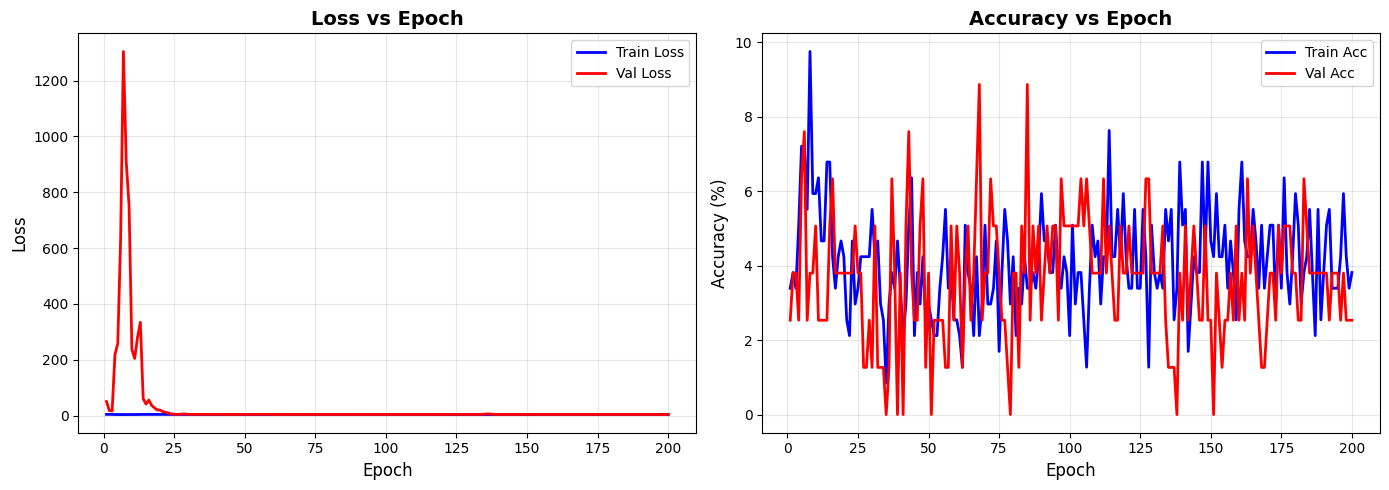

In [60]:
from utils import plot_graph

plot_graph(train_losses, val_losses, train_accs, val_accs, num_epochs=len(train_losses))

Test the SSTAN model.

In [61]:
# create test dataset
test_dataset = SignDataset(test_df, pose_dir, gloss_map)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# load weights
if best_weight_path:
    model.load_state_dict(torch.load(best_weight_path))
    model.to(device)
model.eval()
results = []

test_correct, test_total = 0, 0
test_top5_correct = 0
test_loss = 0.0

with torch.no_grad():
    for idx, batch in enumerate(tqdm(test_loader, desc='Testing')):
        inputs = batch["x"].to(device)
        labels = batch["label"].to(device)
        video_id = batch["video_id"].to(device)

        # forward pass
        logits = model(inputs)
        loss = criterion(logits, labels)

        # accumulate loss
        test_loss += loss.item()

        # top-1 and top-5 predicitons
        _, preds = logits.max(1)
        k = min(5, num_classes)
        _, top5 = logits.topk(k, 1, True, True)

        # store result
        is_correct = (preds == labels).item()
        is_top5 = (labels.unsqueeze(1) == top5).any().item()

        results.append({
            "video_id": video_id.item(),
            "label": labels.item(),
            "pred": preds.item(),
            "is_correct": is_correct
        })

        test_correct += is_correct
        test_top5_correct += is_top5
        test_total += 1

# calculate overall accuracy
test_accuracy = 100. * test_correct / test_total
test_top5_accuracy = 100. * test_top5_correct / test_total
avg_test_loss = test_loss / len(test_loader)

print(f'\nTest Results:')
print(f'Loss: {avg_test_loss:.4f}')
print(f'Top-1 Accuracy: {test_accuracy:.2f}% ({test_correct}/{test_total})')
print(f'Top-5 Accuracy: {test_top5_accuracy:.2f}% ({test_top5_correct}/{test_total})')

Testing: 100%|██████████| 79/79 [00:16<00:00,  4.71it/s]


Test Results:
Loss: 3.5722
Top-1 Accuracy: 1.27% (1/79)
Top-5 Accuracy: 15.19% (12/79)
